# This Notebook will include graphical analysis of Amazon review data

Source:

Justifying recommendations using distantly-labeled reviews and fined-grained aspects.

Jianmo Ni, Jiacheng Li, Julian McAuley.

Empirical Methods in Natural Language Processing (EMNLP), 2019.

https://nijianmo.github.io/amazon/index.html

http://deepyeti.ucsd.edu/jianmo/amazon/index.html

------------------------------

Sentiment analysis code shall be later on transfered to .py files for easy execution

---------------

# Data Transformation

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import math
from scipy.spatial import distance
from sklearn.metrics import accuracy_score
import keras
from keras.models import Sequential
from keras.layers import Dense

# custom files
from word_vectorization import create_tf_vector_all_reviews, create_idf_dictionary, create_word_vector_dict
from data_transformation import get_overview, clean_data, balancing
from knn import knn

Using TensorFlow backend.


--------

## Import Data

In [2]:
# get all files to load

path = "./data"
files = os.listdir(path)
files = [element for element in files if not "FULL" in element]

In [3]:
# load first dataset
data = pd.read_json(path+"/"+files[0], lines = True)

# load other datasets
for i in range(1, len(files)):
    
    tmp_data = pd.read_json(path+"/"+files[i], lines = True)
    data = data.append(tmp_data)

In [4]:
# read subset data
#path = "./data/AMAZON_FASHION_5.json"

# read full data
#path = "./data/AMAZON_FASHION_FULL.json"

#data = pd.read_json(path, lines = True)

-------

# Data overview

In [4]:
get_overview(data)

Data has 28874 datapoints.
Data has 12 columns.
Columns: dtype
{'overall': 'int64', 'verified': 'bool', 'reviewTime': 'object', 'reviewerID': 'object', 'asin': 'object', 'style': 'object', 'reviewerName': 'object', 'reviewText': 'object', 'summary': 'object', 'unixReviewTime': 'int64', 'vote': 'object', 'image': 'object'}


--------

## Data Cleaning

In [5]:
keepColumns = ["overall", "reviewText"]
data = clean_data(data, keepColumns)

Dropped 10 columns.
Droppend 29 null values.
Data contains now 28845 datapoints.


-------

## Balancing

Most saved rating is 5 with 18655 datapoints.
Least saved rating is 2 with 1018 datapoints.


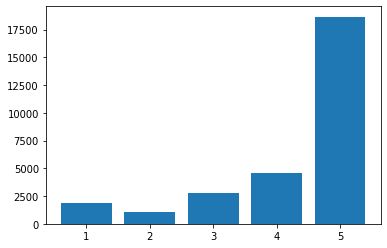

Dataset now contains 5090 datapoints.


In [6]:
max_num = None # replace lateron
data = balancing(data, balancing = True, max_num = max_num)

Most saved rating is 1 with 1018 datapoints.
Least saved rating is 1 with 1018 datapoints.


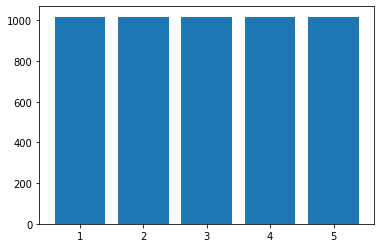

In [7]:
# check balancing
balancing(data, balancing = False, max_num = None)

-------

## Word Vectors

In [8]:
def save_dict_to_json(dic, filename):
    
    # append .json
    filename += ".json"
    
    f = open(filename, "w")
    json.dump(dic, f)
    f.close()

def load_doc_from_json(filename):
    
    # append .json
    filename += ".json"
    
    f = open(filename, "w")
    dic = f.read()
    f.close()

In [9]:
# create review_dict
review_dict = create_tf_vector_all_reviews(data)
#save_dict_to_json(review_dict, "review_dict")

# create idf dict
idf_dict = create_idf_dictionary(review_dict)
#save_dict_to_json(idf_dict, "idf_dict")

# create word_vec_dict
word_vec_dict = create_word_vector_dict(review_dict, idf_dict) # speed = 0.2 seconds per datapoint
#np.save('word_vec_dict.npy', word_vec_dict)

# include word_vec_dict in dataframe
data["word_vectors"] = list(word_vec_dict.values())

In [15]:
# alternative without processing word vectors
#word_vec_dict = np.load('word_vec_dict.npy', allow_pickle=True)[()]
#data["word_vectors"] = word_vec_dict.values()
#data.to_json("data_with_word_vectors")

In [27]:
# get a look at the data
data.head()

,overall,reviewText,test,word_vectors
0,2,Ok looking card (not great). But I would have ...,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2,I ordered a bunch of gift cards and when the p...,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,I ordered a bunch of gift cards and when the p...,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2,Don't like the tin - it looks tacky!,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2,I ordered a bunch of gift cards and when the p...,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


------

## Train Test Split

In [10]:
# create test and training dataset
test_size = 0.2
train_data, test_data = train_test_split(data,
                                         test_size = test_size,
                                         shuffle=True,
                                         stratify = data["overall"]
                                        )

train_data = train_data.reset_index(drop = True)
test_data = test_data.reset_index(drop = True)

-------

# Now start Sentiment analysis

-------

## knn

In [18]:
# test single n

# init variables
data_point = test_data[:1]
data_point_class = int(data_point["overall"])
data_point = np.asarray(data_point["word_vectors"].to_list())
n = 3

# calc class
calc_class = knn(train_data, data_point, n)

print(f"Test Datapoint has class: {calc_class}")
print(f"Original class was {data_point_class}")

Test Datapoint has class: 3
Original class was 3


In [19]:
# test multiple n

# init variables
data_point = test_data[:1]
data_point_class = int(data_point["overall"])
data_point = np.asarray(data_point["word_vectors"].to_list())
n = [1,2,3,4,5]

# calc class
calc_class = knn(train_data, data_point, n)

print(f"Test Datapoint has class: {calc_class}")
print(f"Original class was {data_point_class}")

Test Datapoint has class: {1: 3, 2: 3, 3: 3, 4: 3, 5: 3}
Original class was 3


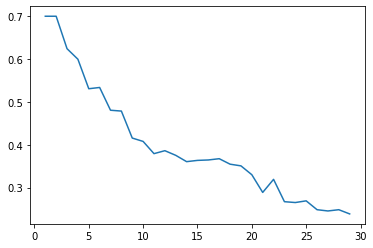

In [20]:
# test accuracy

# get test data
test_vectors = test_data["word_vectors"].to_list()
test_classes = test_data["overall"].to_list()

# init variables
pred_class = []
n_test = list(range(1,30))

# get classes
count = 0
for t_vector in test_vectors:

    pred_class.append(knn(train_data, np.asarray(t_vector), n_test))
    
    count += 1
    if (count % 100) == 0:
        
        print(f"Step {count}")
    
# init accuracy dict
acc_dict = {}

for sub_n in n_test:
    
    sub_n_val_classes = []
    
    for test_el in pred_class:
        
        sub_n_val_classes.append(test_el[sub_n])
    
    # get accuracy of sub_n
    accuracy = accuracy_score(test_classes, sub_n_val_classes)
    acc_dict[sub_n] = accuracy

# visualize
plt.plot(list(acc_dict.keys()), list(acc_dict.values()))
plt.show()

----

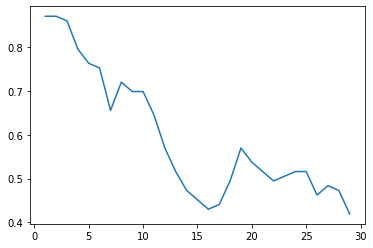

In [98]:
# visualize 
plt.plot(list(evalualtion_dict.keys()), list(evalualtion_dict.values()))
plt.show()

----------

## Neural Network

In [38]:
# build train and test data
x_train = train_data["word_vectors"].to_numpy()
y_train = train_data["overall"].to_numpy()

x_test = test_data["word_vectors"].to_numpy()
y_test = test_data["overall"].to_numpy()

# list of tuples to list of lists
x_train = [list(sub_tuple) for sub_tuple in x_train]
x_test = [list(sub_tuple) for sub_tuple in x_test]

x_train = np.array(x_train)
x_test = np.array(x_test)

# shape
shape = len(x_train[1:2][0])

In [39]:
y_train = train_data["overall"].to_numpy()
y_test = test_data["overall"].to_numpy()

In [40]:
# reshape data
x_train = x_train.reshape(len(x_train), shape).astype("float32") / 255
x_test = x_test.reshape(len(x_test), shape).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

In [41]:
# build validation data for training
perc = 0.05
scope = round(len(x_train)*perc)

x_val = x_train[:scope]
x_train = x_train[scope:]

y_val = y_train[:scope]
y_train = y_train[scope:]

In [42]:
int(1.5)

1

In [49]:
from keras import layers
inputs = keras.Input(shape=(shape,), name="wordvecors")
x = layers.Dense(256, activation="sigmoid", name="dense_1")(inputs)
x = layers.Dense(128, activation="relu", name="dense_2")(x)
x = layers.Dense(64, activation="sigmoid", name="dense_3")(x)
x = layers.Dense(32, activation="sigmoid", name="dense_4")(x)
x = layers.Dense(16, activation="relu", name="dense_5")(x)
outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [50]:
model.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

In [ ]:
print("Fit model on training data")
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=1000,
    validation_data=(x_val, y_val),
)

Fit model on training data
Train on 3868 samples, validate on 204 samples
Epoch 1/1000
3868/3868 [==============================] - 1s 345us/step - loss: 1.6115 - sparse_categorical_accuracy: 0.1929 - val_loss: 1.6085 - val_sparse_categorical_accuracy: 0.2108
Epoch 2/1000
3868/3868 [==============================] - 1s 347us/step - loss: 1.6120 - sparse_categorical_accuracy: 0.1900 - val_loss: 1.6166 - val_sparse_categorical_accuracy: 0.1814
Epoch 3/1000
3868/3868 [==============================] - 1s 355us/step - loss: 1.6123 - sparse_categorical_accuracy: 0.1859 - val_loss: 1.6121 - val_sparse_categorical_accuracy: 0.1814
Epoch 4/1000
3868/3868 [==============================] - 1s 359us/step - loss: 1.6122 - sparse_categorical_accuracy: 0.2022 - val_loss: 1.6146 - val_sparse_categorical_accuracy: 0.1814
Epoch 5/1000
3868/3868 [==============================] - 1s 358us/step - loss: 1.6124 - sparse_categorical_accuracy: 0.1954 - val_loss: 1.6141 - val_sparse_categorical_accuracy: 0.1

3868/3868 [==============================] - 1s 324us/step - loss: 1.6111 - sparse_categorical_accuracy: 0.1960 - val_loss: 1.6064 - val_sparse_categorical_accuracy: 0.2255
Epoch 45/1000
3868/3868 [==============================] - 1s 314us/step - loss: 1.6115 - sparse_categorical_accuracy: 0.1892 - val_loss: 1.6108 - val_sparse_categorical_accuracy: 0.1814
Epoch 46/1000
3868/3868 [==============================] - 1s 319us/step - loss: 1.6117 - sparse_categorical_accuracy: 0.1856 - val_loss: 1.6108 - val_sparse_categorical_accuracy: 0.1863
Epoch 47/1000
3868/3868 [==============================] - 1s 320us/step - loss: 1.6112 - sparse_categorical_accuracy: 0.1867 - val_loss: 1.6101 - val_sparse_categorical_accuracy: 0.2108
Epoch 48/1000
3868/3868 [==============================] - 1s 315us/step - loss: 1.6111 - sparse_categorical_accuracy: 0.1983 - val_loss: 1.6097 - val_sparse_categorical_accuracy: 0.2108
Epoch 49/1000
3868/3868 [==============================] - 1s 327us/step - loss

Epoch 88/1000
3868/3868 [==============================] - 1s 323us/step - loss: 1.6108 - sparse_categorical_accuracy: 0.1929 - val_loss: 1.6075 - val_sparse_categorical_accuracy: 0.2108
Epoch 89/1000
3868/3868 [==============================] - 1s 317us/step - loss: 1.6110 - sparse_categorical_accuracy: 0.1900 - val_loss: 1.6084 - val_sparse_categorical_accuracy: 0.1961
Epoch 90/1000
3868/3868 [==============================] - 1s 323us/step - loss: 1.6109 - sparse_categorical_accuracy: 0.1903 - val_loss: 1.6112 - val_sparse_categorical_accuracy: 0.1814
Epoch 91/1000
3868/3868 [==============================] - 1s 321us/step - loss: 1.6110 - sparse_categorical_accuracy: 0.1833 - val_loss: 1.6096 - val_sparse_categorical_accuracy: 0.2108
Epoch 92/1000
3868/3868 [==============================] - 1s 319us/step - loss: 1.6108 - sparse_categorical_accuracy: 0.1949 - val_loss: 1.6146 - val_sparse_categorical_accuracy: 0.1863
Epoch 93/1000
3868/3868 [==============================] - 1s 315

Epoch 132/1000
3868/3868 [==============================] - 1s 317us/step - loss: 1.6104 - sparse_categorical_accuracy: 0.1980 - val_loss: 1.6077 - val_sparse_categorical_accuracy: 0.2255
Epoch 133/1000
3868/3868 [==============================] - 1s 322us/step - loss: 1.6108 - sparse_categorical_accuracy: 0.1864 - val_loss: 1.6097 - val_sparse_categorical_accuracy: 0.1863
Epoch 134/1000
3868/3868 [==============================] - 1s 317us/step - loss: 1.6102 - sparse_categorical_accuracy: 0.1939 - val_loss: 1.6113 - val_sparse_categorical_accuracy: 0.1863
Epoch 135/1000
3868/3868 [==============================] - 1s 318us/step - loss: 1.6106 - sparse_categorical_accuracy: 0.1926 - val_loss: 1.6099 - val_sparse_categorical_accuracy: 0.1863
Epoch 136/1000
3868/3868 [==============================] - 1s 322us/step - loss: 1.6105 - sparse_categorical_accuracy: 0.1905 - val_loss: 1.6092 - val_sparse_categorical_accuracy: 0.1961
Epoch 137/1000
3868/3868 [==============================] - 

3868/3868 [==============================] - 1s 337us/step - loss: 1.6101 - sparse_categorical_accuracy: 0.1931 - val_loss: 1.6098 - val_sparse_categorical_accuracy: 0.1814
Epoch 176/1000
3868/3868 [==============================] - 1s 330us/step - loss: 1.6102 - sparse_categorical_accuracy: 0.1880 - val_loss: 1.6097 - val_sparse_categorical_accuracy: 0.1961
Epoch 177/1000
3868/3868 [==============================] - 1s 337us/step - loss: 1.6099 - sparse_categorical_accuracy: 0.1898 - val_loss: 1.6091 - val_sparse_categorical_accuracy: 0.2108
Epoch 178/1000
3868/3868 [==============================] - 1s 333us/step - loss: 1.6100 - sparse_categorical_accuracy: 0.1905 - val_loss: 1.6104 - val_sparse_categorical_accuracy: 0.1863
Epoch 179/1000
3868/3868 [==============================] - 1s 333us/step - loss: 1.6100 - sparse_categorical_accuracy: 0.1931 - val_loss: 1.6122 - val_sparse_categorical_accuracy: 0.1863
Epoch 180/1000
3868/3868 [==============================] - 1s 335us/step -

Epoch 219/1000
3868/3868 [==============================] - 1s 330us/step - loss: 1.6099 - sparse_categorical_accuracy: 0.1952 - val_loss: 1.6099 - val_sparse_categorical_accuracy: 0.1863
Epoch 220/1000
3868/3868 [==============================] - 1s 350us/step - loss: 1.6098 - sparse_categorical_accuracy: 0.2014 - val_loss: 1.6116 - val_sparse_categorical_accuracy: 0.1863
Epoch 221/1000
3868/3868 [==============================] - 1s 351us/step - loss: 1.6099 - sparse_categorical_accuracy: 0.1892 - val_loss: 1.6102 - val_sparse_categorical_accuracy: 0.1863
Epoch 222/1000
3868/3868 [==============================] - 1s 331us/step - loss: 1.6099 - sparse_categorical_accuracy: 0.1916 - val_loss: 1.6095 - val_sparse_categorical_accuracy: 0.1814
Epoch 223/1000
3868/3868 [==============================] - 1s 334us/step - loss: 1.6099 - sparse_categorical_accuracy: 0.1828 - val_loss: 1.6094 - val_sparse_categorical_accuracy: 0.1961
Epoch 224/1000
3868/3868 [==============================] - 

3868/3868 [==============================] - 1s 336us/step - loss: 1.6098 - sparse_categorical_accuracy: 0.1954 - val_loss: 1.6096 - val_sparse_categorical_accuracy: 0.1814
Epoch 263/1000
3868/3868 [==============================] - 1s 331us/step - loss: 1.6097 - sparse_categorical_accuracy: 0.1962 - val_loss: 1.6092 - val_sparse_categorical_accuracy: 0.2255
Epoch 264/1000
3868/3868 [==============================] - 1s 338us/step - loss: 1.6098 - sparse_categorical_accuracy: 0.1851 - val_loss: 1.6098 - val_sparse_categorical_accuracy: 0.1814
Epoch 265/1000
3868/3868 [==============================] - 1s 338us/step - loss: 1.6098 - sparse_categorical_accuracy: 0.1988 - val_loss: 1.6099 - val_sparse_categorical_accuracy: 0.1814
Epoch 266/1000
3868/3868 [==============================] - 1s 332us/step - loss: 1.6097 - sparse_categorical_accuracy: 0.1991 - val_loss: 1.6098 - val_sparse_categorical_accuracy: 0.1814
Epoch 267/1000
3868/3868 [==============================] - 1s 335us/step -

Epoch 306/1000
3868/3868 [==============================] - 1s 355us/step - loss: 1.6097 - sparse_categorical_accuracy: 0.1931 - val_loss: 1.6100 - val_sparse_categorical_accuracy: 0.1863
Epoch 307/1000
3868/3868 [==============================] - 1s 359us/step - loss: 1.6097 - sparse_categorical_accuracy: 0.1954 - val_loss: 1.6096 - val_sparse_categorical_accuracy: 0.1961
Epoch 308/1000
3868/3868 [==============================] - 1s 348us/step - loss: 1.6097 - sparse_categorical_accuracy: 0.1952 - val_loss: 1.6101 - val_sparse_categorical_accuracy: 0.1863
Epoch 309/1000
3868/3868 [==============================] - 1s 347us/step - loss: 1.6097 - sparse_categorical_accuracy: 0.2001 - val_loss: 1.6095 - val_sparse_categorical_accuracy: 0.1961
Epoch 310/1000
3868/3868 [==============================] - 1s 356us/step - loss: 1.6097 - sparse_categorical_accuracy: 0.1921 - val_loss: 1.6097 - val_sparse_categorical_accuracy: 0.1814
Epoch 311/1000
3868/3868 [==============================] - 

3868/3868 [==============================] - 1s 335us/step - loss: 1.6096 - sparse_categorical_accuracy: 0.1960 - val_loss: 1.6101 - val_sparse_categorical_accuracy: 0.1863
Epoch 350/1000
3868/3868 [==============================] - 1s 336us/step - loss: 1.6097 - sparse_categorical_accuracy: 0.1929 - val_loss: 1.6103 - val_sparse_categorical_accuracy: 0.1863
Epoch 351/1000
3868/3868 [==============================] - 1s 343us/step - loss: 1.6097 - sparse_categorical_accuracy: 0.1947 - val_loss: 1.6100 - val_sparse_categorical_accuracy: 0.1863
Epoch 352/1000
3868/3868 [==============================] - 1s 336us/step - loss: 1.6096 - sparse_categorical_accuracy: 0.1898 - val_loss: 1.6100 - val_sparse_categorical_accuracy: 0.1863
Epoch 353/1000
3868/3868 [==============================] - 1s 340us/step - loss: 1.6097 - sparse_categorical_accuracy: 0.1954 - val_loss: 1.6098 - val_sparse_categorical_accuracy: 0.1863
Epoch 354/1000
3868/3868 [==============================] - 1s 348us/step -

Epoch 393/1000
3868/3868 [==============================] - 1s 345us/step - loss: 1.6098 - sparse_categorical_accuracy: 0.1880 - val_loss: 1.6100 - val_sparse_categorical_accuracy: 0.1814
Epoch 394/1000
3868/3868 [==============================] - 1s 332us/step - loss: 1.6097 - sparse_categorical_accuracy: 0.1939 - val_loss: 1.6100 - val_sparse_categorical_accuracy: 0.1814
Epoch 395/1000
3868/3868 [==============================] - 1s 335us/step - loss: 1.6097 - sparse_categorical_accuracy: 0.1931 - val_loss: 1.6104 - val_sparse_categorical_accuracy: 0.1814
Epoch 396/1000
3868/3868 [==============================] - 1s 340us/step - loss: 1.6097 - sparse_categorical_accuracy: 0.2001 - val_loss: 1.6099 - val_sparse_categorical_accuracy: 0.1863
Epoch 397/1000
3868/3868 [==============================] - 1s 337us/step - loss: 1.6097 - sparse_categorical_accuracy: 0.2004 - val_loss: 1.6099 - val_sparse_categorical_accuracy: 0.1863
Epoch 398/1000
3868/3868 [==============================] - 

3868/3868 [==============================] - 1s 344us/step - loss: 1.6097 - sparse_categorical_accuracy: 0.1965 - val_loss: 1.6097 - val_sparse_categorical_accuracy: 0.1814
Epoch 437/1000
3868/3868 [==============================] - 1s 374us/step - loss: 1.6096 - sparse_categorical_accuracy: 0.2006 - val_loss: 1.6096 - val_sparse_categorical_accuracy: 0.1961
Epoch 438/1000
3868/3868 [==============================] - 1s 340us/step - loss: 1.6097 - sparse_categorical_accuracy: 0.1944 - val_loss: 1.6100 - val_sparse_categorical_accuracy: 0.1863
Epoch 439/1000
3868/3868 [==============================] - 1s 342us/step - loss: 1.6096 - sparse_categorical_accuracy: 0.2011 - val_loss: 1.6099 - val_sparse_categorical_accuracy: 0.1814
Epoch 440/1000
3868/3868 [==============================] - 1s 337us/step - loss: 1.6097 - sparse_categorical_accuracy: 0.1923 - val_loss: 1.6098 - val_sparse_categorical_accuracy: 0.1814
Epoch 441/1000
3868/3868 [==============================] - 1s 337us/step -

Epoch 480/1000
3868/3868 [==============================] - 1s 333us/step - loss: 1.6096 - sparse_categorical_accuracy: 0.1900 - val_loss: 1.6096 - val_sparse_categorical_accuracy: 0.1961
Epoch 481/1000
3868/3868 [==============================] - 1s 336us/step - loss: 1.6097 - sparse_categorical_accuracy: 0.1877 - val_loss: 1.6099 - val_sparse_categorical_accuracy: 0.1863
Epoch 482/1000
3868/3868 [==============================] - 1s 341us/step - loss: 1.6096 - sparse_categorical_accuracy: 0.1903 - val_loss: 1.6097 - val_sparse_categorical_accuracy: 0.1961
Epoch 483/1000
3868/3868 [==============================] - 1s 334us/step - loss: 1.6096 - sparse_categorical_accuracy: 0.1885 - val_loss: 1.6100 - val_sparse_categorical_accuracy: 0.1863
Epoch 484/1000
3868/3868 [==============================] - 1s 336us/step - loss: 1.6096 - sparse_categorical_accuracy: 0.1926 - val_loss: 1.6099 - val_sparse_categorical_accuracy: 0.1863
Epoch 485/1000
3868/3868 [==============================] - 

3868/3868 [==============================] - 1s 342us/step - loss: 1.6095 - sparse_categorical_accuracy: 0.1993 - val_loss: 1.6098 - val_sparse_categorical_accuracy: 0.1961
Epoch 524/1000
3868/3868 [==============================] - 1s 333us/step - loss: 1.6095 - sparse_categorical_accuracy: 0.1973 - val_loss: 1.6098 - val_sparse_categorical_accuracy: 0.1814
Epoch 525/1000
3868/3868 [==============================] - 1s 355us/step - loss: 1.6095 - sparse_categorical_accuracy: 0.1960 - val_loss: 1.6098 - val_sparse_categorical_accuracy: 0.1863
Epoch 526/1000
3868/3868 [==============================] - 1s 339us/step - loss: 1.6096 - sparse_categorical_accuracy: 0.1975 - val_loss: 1.6098 - val_sparse_categorical_accuracy: 0.1814
Epoch 527/1000
3868/3868 [==============================] - 1s 327us/step - loss: 1.6095 - sparse_categorical_accuracy: 0.1936 - val_loss: 1.6098 - val_sparse_categorical_accuracy: 0.1863
Epoch 528/1000
3868/3868 [==============================] - 1s 328us/step -

Epoch 567/1000
3868/3868 [==============================] - 1s 334us/step - loss: 1.6095 - sparse_categorical_accuracy: 0.1960 - val_loss: 1.6098 - val_sparse_categorical_accuracy: 0.1814
Epoch 568/1000
3868/3868 [==============================] - 1s 332us/step - loss: 1.6095 - sparse_categorical_accuracy: 0.1960 - val_loss: 1.6097 - val_sparse_categorical_accuracy: 0.1863
Epoch 569/1000
3868/3868 [==============================] - 1s 330us/step - loss: 1.6096 - sparse_categorical_accuracy: 0.1978 - val_loss: 1.6098 - val_sparse_categorical_accuracy: 0.1863
Epoch 570/1000
3868/3868 [==============================] - 1s 342us/step - loss: 1.6095 - sparse_categorical_accuracy: 0.1978 - val_loss: 1.6099 - val_sparse_categorical_accuracy: 0.1863
Epoch 571/1000
3868/3868 [==============================] - 1s 351us/step - loss: 1.6095 - sparse_categorical_accuracy: 0.1913 - val_loss: 1.6099 - val_sparse_categorical_accuracy: 0.1814
Epoch 572/1000
3868/3868 [==============================] - 

In [19]:
history.history.keys()

dict_keys(['val_loss', 'val_sparse_categorical_accuracy', 'loss', 'sparse_categorical_accuracy'])

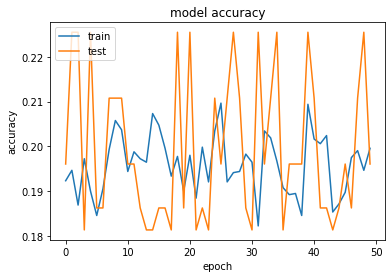

In [52]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
# LSTM Network
from keras.models import Sequential
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate
from keras.layers.recurrent import LSTM


# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=shape))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=2)

TypeError: 'int' object is not iterable

In [32]:
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

RuntimeError: You must compile a model before training/testing. Use `model.compile(optimizer, loss)`.

In [140]:
model = Sequential()
model.add(Dense(12, input_dim=shape, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=150, batch_size=10)

Epoch 1/150
3868/3868 [==============================] - 1s 247us/step - loss: -4.6771 - accuracy: 0.1973
Epoch 2/150
3868/3868 [==============================] - 1s 201us/step - loss: -61.4491 - accuracy: 0.1980
Epoch 3/150
3868/3868 [==============================] - 1s 201us/step - loss: -249.4079 - accuracy: 0.1980
Epoch 4/150
3868/3868 [==============================] - 1s 209us/step - loss: -627.5936 - accuracy: 0.1980
Epoch 5/150
3868/3868 [==============================] - 1s 203us/step - loss: -1230.7489 - accuracy: 0.1980
Epoch 6/150
3868/3868 [==============================] - 1s 205us/step - loss: -2079.3780 - accuracy: 0.1980
Epoch 7/150
3868/3868 [==============================] - 1s 207us/step - loss: -3198.6737 - accuracy: 0.1980
Epoch 8/150
3868/3868 [==============================] - 1s 201us/step - loss: -4603.5807 - accuracy: 0.1980
Epoch 9/150
3868/3868 [==============================] - 1s 208us/step - loss: -6305.2527 - accuracy: 0.1980
Epoch 10/150
3868/3868 [==

3868/3868 [==============================] - 1s 209us/step - loss: -1362934.7103 - accuracy: 0.1980
Epoch 75/150
3868/3868 [==============================] - 1s 207us/step - loss: -1412308.0720 - accuracy: 0.1980
Epoch 76/150
3868/3868 [==============================] - 1s 202us/step - loss: -1462843.0123 - accuracy: 0.1980
Epoch 77/150
3868/3868 [==============================] - 1s 208us/step - loss: -1514583.2226 - accuracy: 0.1980
Epoch 78/150
3868/3868 [==============================] - 1s 207us/step - loss: -1567546.9190 - accuracy: 0.1980
Epoch 79/150
3868/3868 [==============================] - 1s 213us/step - loss: -1621672.9086 - accuracy: 0.1980
Epoch 80/150
3868/3868 [==============================] - 1s 210us/step - loss: -1676895.9322 - accuracy: 0.1980
Epoch 81/150
3868/3868 [==============================] - 1s 203us/step - loss: -1733295.9013 - accuracy: 0.1980
Epoch 82/150
3868/3868 [==============================] - 1s 207us/step - loss: -1791010.2994 - accuracy: 0.1

3868/3868 [==============================] - 1s 213us/step - loss: -8570590.4113 - accuracy: 0.1980
Epoch 147/150
3868/3868 [==============================] - 1s 215us/step - loss: -8733348.5809 - accuracy: 0.1980
Epoch 148/150
3868/3868 [==============================] - 1s 213us/step - loss: -8898117.3325 - accuracy: 0.1980
Epoch 149/150
3868/3868 [==============================] - 1s 219us/step - loss: -9064606.7403 - accuracy: 0.1980
Epoch 150/150
3868/3868 [==============================] - 1s 212us/step - loss: -9233140.0416 - accuracy: 0.1980


-------------